In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [3]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [7]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()

/var/folders/sw/q0vghxyj0cs6_3glp9q55pq80000gp/T/ipykernel_27604/3543858584.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


In [11]:
tavily.invoke("Provide recent news in kerala")

[{'title': 'Kerala - Latest news, Live Updates, Politics, Events - The Hindu',
  'url': 'https://www.thehindu.com/news/national/kerala/',
  'content': '### One drowns, another missing in Achencoil river\n\n### Minister to open Bishop Valloppilly Memorial Museum on August 30\n\n### Suspension of vigilance court employee over secret recordings sparks row\n\n### IndiGo, Air India Express add more flights for Kannur airport ahead of Onam\n\nArtistes perform during the ‘Athachamayam’ procession marking the beginning of the annual harvest festival of Onam at Thripunithura in Ernakulam, Kerala, on Tuesday. [...] ### Atham pageantry heralds Onam in Kerala with artistic fervour, social messages\n\nAuthorities have intensified surveillance around the Kannur Central jail premises following the arrest of the accused.\n\n### Kannur jail smuggling racket: Youth admits to throwing ganja, mobiles inside for cash\n\nKerala Leader of the Opposition V.D. Satheesan  (file)")\n\n### Kerala Opposition Leade

In [13]:
tools=[arxiv,wiki,tavily]

In [14]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="gemma2-9b-it")
llm_with_tools=llm.bind_tools(tools)



In [15]:
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is recent AI news?")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's9pvw4zbt', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 1286, 'total_tokens': 1374, 'completion_time': 0.16, 'prompt_time': 0.024393314, 'queue_time': 0.256373775, 'total_time': 0.184393314}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ae238737-3097-408b-b0c5-9aed44201202-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 's9pvw4zbt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1286, 'output_tokens': 88, 'total_tokens': 1374})

#CHATBOT

In [17]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from  langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]


In [21]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}


In [23]:
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)

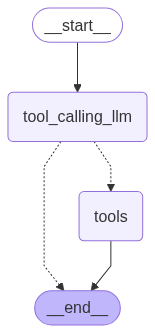

In [25]:
from langgraph import graph


graph=builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))